# Importing neccessary libraries and dataset

A few techniques used here: SMOTE, K-means, Random Forest, Naive Bayes, nltk (lemmatization, tokenization)

In [1]:
import string # from some string manipulation tasks
import nltk # natural language toolkit
import re # regex
from string import punctuation # solving punctuation problems
from nltk.corpus import stopwords # stop words in sentences
from nltk.stem import WordNetLemmatizer # For stemming the sentence
from nltk.stem import SnowballStemmer # For stemming the sentence
from contractions import contractions_dict # to solve contractions
from autocorrect import Speller #correcting the spellings
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

#Libraries for general purpose
import matplotlib.pyplot as plt
import seaborn as sns


#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yashk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\yashk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yashk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv(r'C:\Users\yashk\OneDrive\Documents\Notebooks\cyberbullying_tweets.csv')
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

**There is not much imbalance between different cyberbulling type. other_cyberbulling will be removed since it may cause a confusion for the models with other cyberbullying class.**

In [3]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

# Dataset Preprocessing

In [4]:
# Renaming Categories
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'type_of_hate_speech'})

In [5]:
# Checking 10 samples
df.sample(10)

,text,type_of_hate_speech
18941,most muslim countries ban porn no evidence and...,religion
36503,"Minutes while watching the movie, I remembered...",age
47407,@Super_Man12 stfu dumb nigger ill fuck yo mama...,ethnicity
1292,"Dou um empurrão em uma pessoa, isso se chama :...",not_cyberbullying
39161,so are we gonna ignore how 2 of your fandoms a...,age
6423,Watched college football &amp; basketball all ...,not_cyberbullying
6332,Its Leeteuk's turn to be bullied,not_cyberbullying
42,Fuck this paper bullshit,not_cyberbullying
11584,Ion have to google nothing to know what words ...,gender
45653,nothing malicious about the pic at all. They a...,ethnicity


**Converting categories into numbers**

In [6]:
df["type_of_hate_speech"].replace({"religion": 0, "age": 1, "gender": 2, "ethnicity": 3, "not_cyberbullying": 4}, inplace=True)
df

,text,type_of_hate_speech
0,"In other words #katandandre, your food was cra...",4
1,Why is #aussietv so white? #MKR #theblock #ImA...,4
2,@XochitlSuckkks a classy whore? Or more red ve...,4
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4
4,@RudhoeEnglish This is an ISIS account pretend...,4
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",3
47688,Turner did not withhold his disappointment. Tu...,3
47689,I swear to God. This dumb nigger bitch. I have...,3
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,3


In [7]:
typeofhate = ["religion","age","gender","ethnicity","not_hatespeech"]

(array([7998.,    0., 7992.,    0.,    0., 7973.,    0., 7961.,    0.,
        7945.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

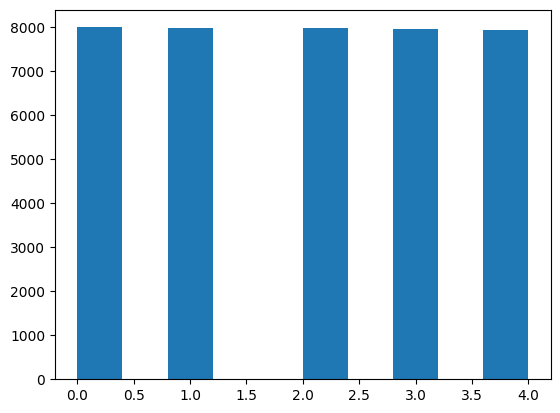

In [8]:
plt.hist(df.type_of_hate_speech)

**Preprocessing: Tokenize sentences, Change to lower case, Correct spelling, Remove numbers, Remove punctuation, Remove stopwords, Normalize (Lemmatize or Lemmatization)**

**Predefined functions for text cleaning**

In [9]:
# We shall clean our text here:

#Text cleaning
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english')) #set of stopwords

#Clean emoji
def strip_emoji(text):
    return emoji.demojize(text) #convert emoji to text

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text


#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Preprocess function
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [10]:
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))

In [11]:
df['text_clean'] = texts_cleaned

**Clean text**

In [12]:
df.head()

,text,type_of_hate_speech,text_clean
0,"In other words #katandandre, your food was cra...",4,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,4,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,4,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,4,isi account pretend kurdish account like islam...


**Checking for duplicate tweets**

In [13]:
df["text_clean"].duplicated().sum()

1037

**The given data has 1037 duplicates. We remove them here**

In [14]:
df.drop_duplicates("text_clean", inplace=True)
df.dropna(inplace=True)

**Find counts of all sentiments**

In [15]:
df.type_of_hate_speech.value_counts() 

0    7946
1    7884
3    7746
4    7645
2    7611
Name: type_of_hate_speech, dtype: int64

**After removing duplicates, the value counts per sentiment is shown above. </br>
There is only a few difference (350) on the sentiment with most text and the sentiment with least text so there is no major imbalance on the data.**

# Checking tweet length

In [16]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split()) #splitting the text into words
    text_len.append(tweet_len)

In [17]:
df['text_len'] = text_len

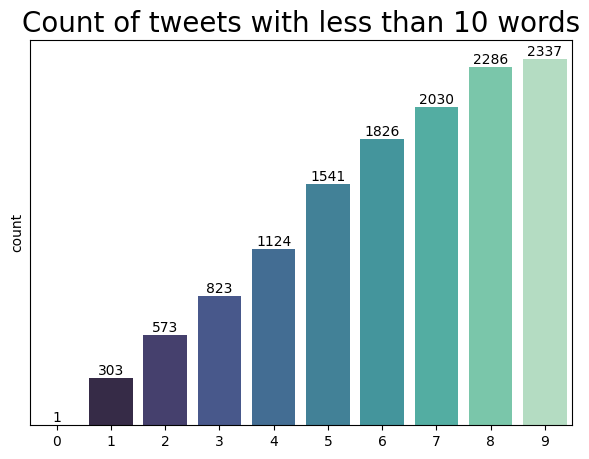

In [18]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [19]:
# checking long tweets
df.sort_values(by=['text_len'], ascending=False)

,text,type_of_hate_speech,text_clean,text_len
44035,You so black and white trying to live like a n...,3,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",3,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",1,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,4,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,3,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
1554,Greater is he that is in me.,4,greater,1
12398,@RaidersGirl20 How is that sexist?,2,sexist,1
7538,@Mayi_FirstClass FOLLOW ME,4,follow,1
4485,@youngesttyler school :-/,4,school,1


**Removing tweets with less than 2 words and more than 120 words as they can be outliers**

In [20]:
df = df[df['text_len'] > 2]
df = df[df['text_len'] < 120]

In [21]:
df

,text,type_of_hate_speech,text_clean,text_len
0,"In other words #katandandre, your food was cra...",4,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,4,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,4,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,4,isi account pretend kurdish account like islam...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",3,black ppl expect anyth depend anyth yet free p...,21
47688,Turner did not withhold his disappointment. Tu...,3,turner withhold turner call court abomin concl...,28
47689,I swear to God. This dumb nigger bitch. I have...,3,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,3,yea fuck rt your nigger fuck unfollow fuck dum...,10


# Creating a word cloud

In [22]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt #to display our wordcloud
from PIL import Image #to load our image
import numpy as np #to get the color of our image
%matplotlib inline

**0 - religion </br>
1 - age  </br> 
2 - gender </br>
3 - ethnicity </br>
4 - other_hatespeech**

C:\Users\yashk\AppData\Local\Temp\ipykernel_13304\14592260.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.sentiment = lenc.fit_transform(df.type_of_hate_speech)


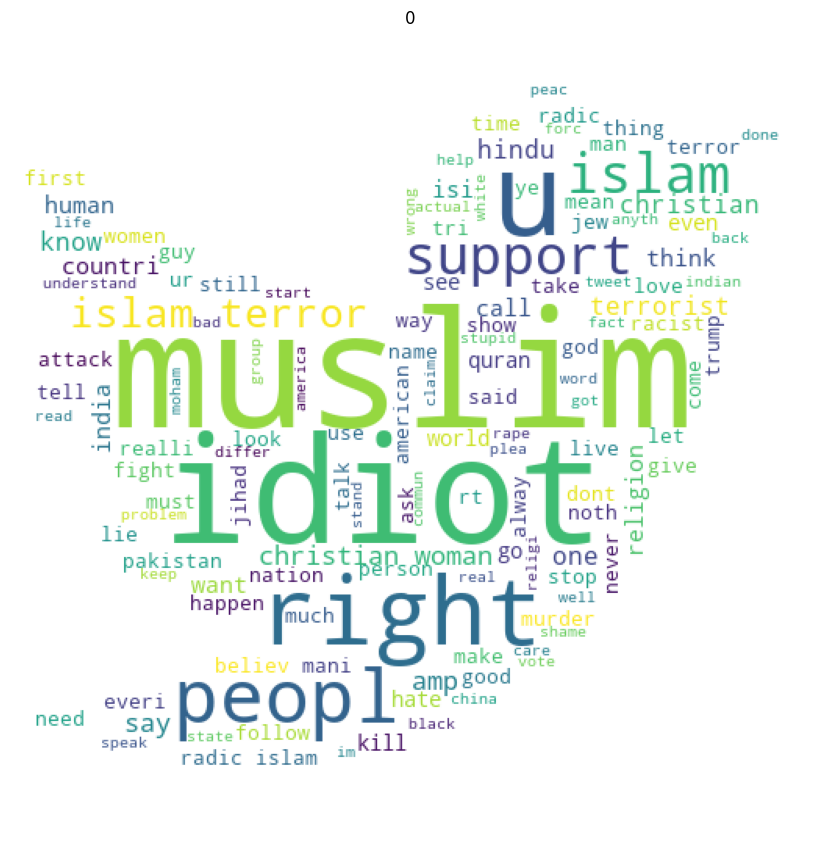

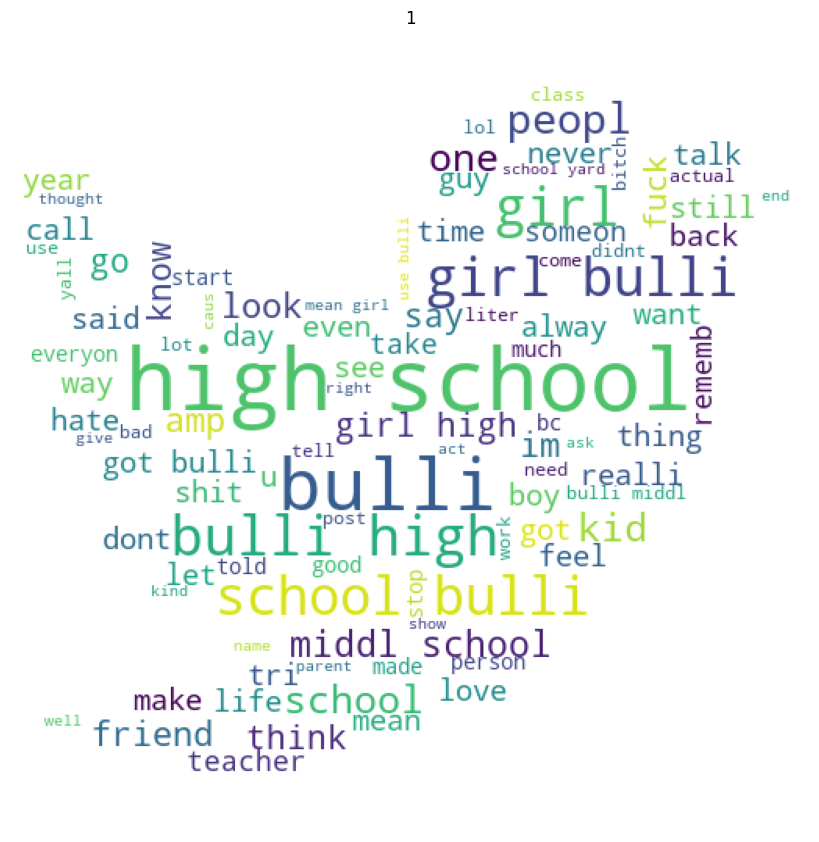

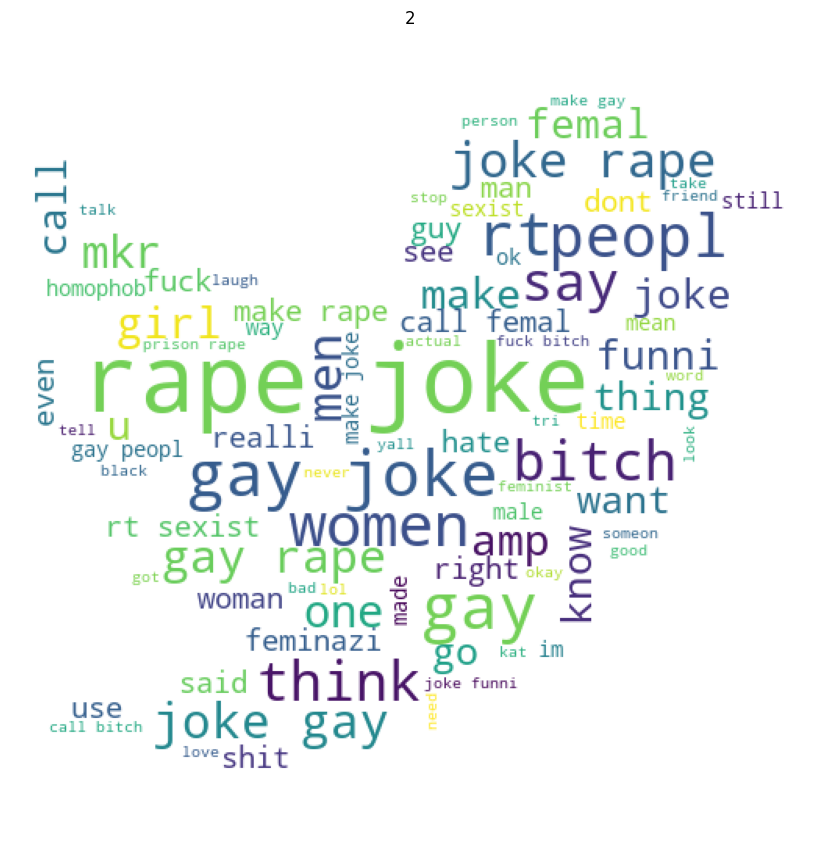

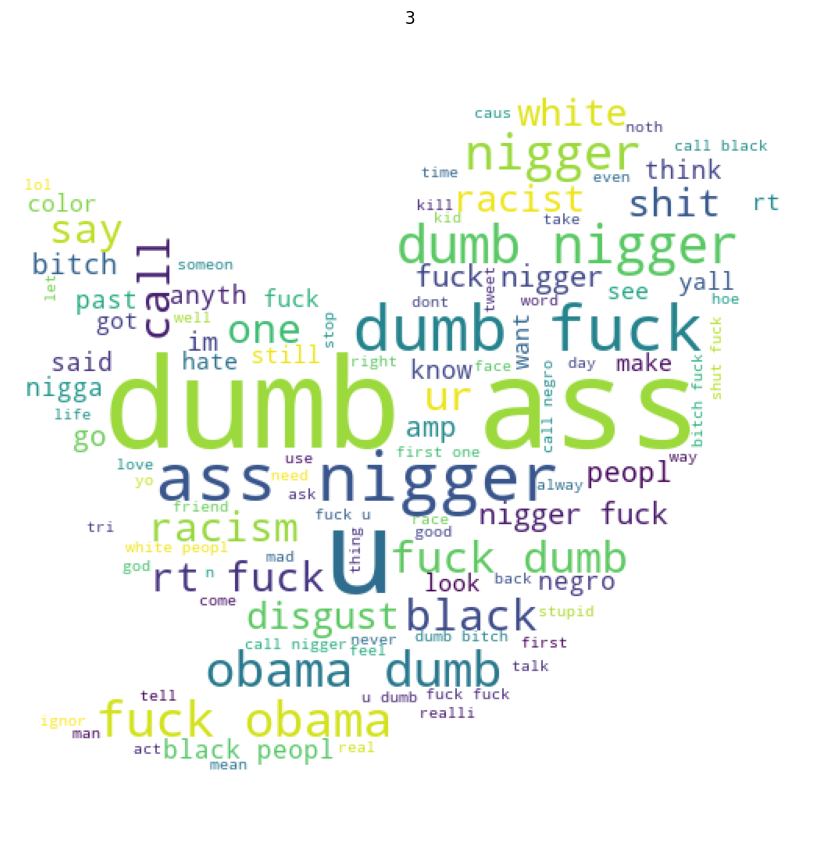

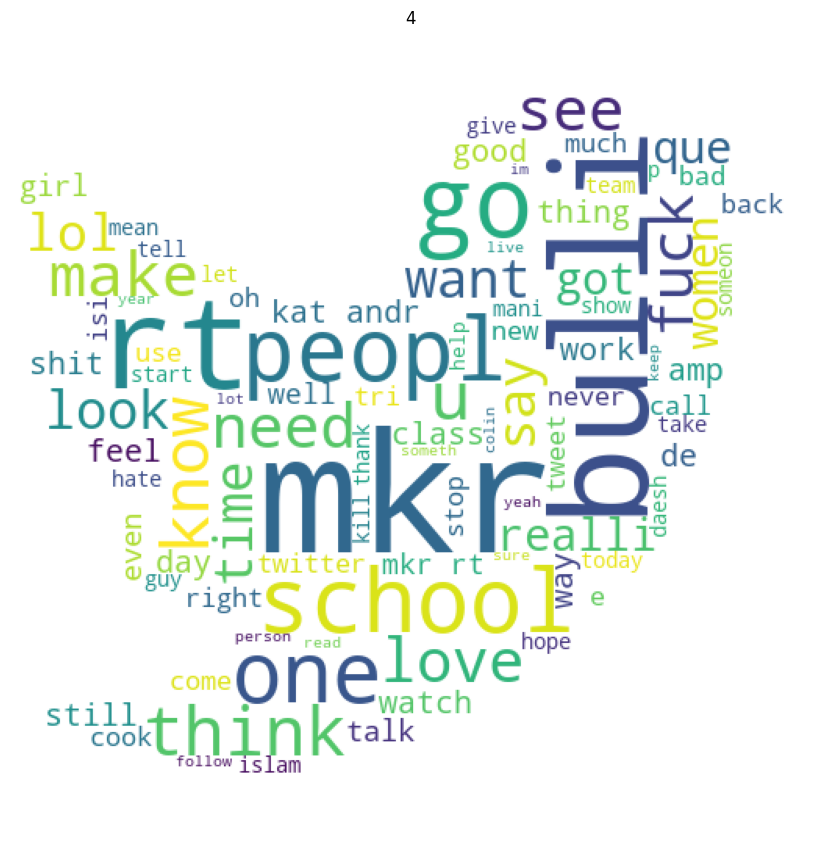

In [23]:

from sklearn.preprocessing import LabelEncoder

lenc = LabelEncoder()
df.sentiment = lenc.fit_transform(df.type_of_hate_speech)
#Gotta invert the mask
custom_mask = np.array(Image.open(r'C:\Users\yashk\Downloads\twitter.png'))
custom_mask=np.invert(custom_mask)


for c in range(len(lenc.classes_)):
    string = ""
    for i in df[df.sentiment == c].text_clean.values:
        string = string + " " + i.strip()

 
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                mask = custom_mask,
                min_font_size = 10).generate(string)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    #add title "Wordcloud for hate speech on religion"
    
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(lenc.classes_[c])
    plt.show()
    del string

# Turning text into numbers

In [24]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


tfidf = TfidfTransformer() 
clf = CountVectorizer()

X_cv =  clf.fit_transform(df['text_clean'])

tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)   

In [25]:
X_tf

<37948x33165 sparse matrix of type '<class 'numpy.float64'>'
	with 507306 stored elements in Compressed Sparse Row format>

# Train test split

In [26]:

from sklearn.model_selection import train_test_split
# train and test
# We do stratify, to ensure that almost equal number of values come from each type_of_hate_speech 
X_train, X_test, y_train, y_test = train_test_split(X_tf, df['type_of_hate_speech'], test_size=0.20, stratify=df['type_of_hate_speech'], random_state=42)

In [27]:
y_train.value_counts()
#y_train index must start from zero
y_train.reset_index(drop=True, inplace=True)
y_train.value_counts()

0    6350
1    6295
3    6186
2    5960
4    5567
Name: type_of_hate_speech, dtype: int64

**after checking the training set, there are imbalance of data and it may cause a bias in training the model. Oversampling using SMOTE will be used to balance the train dataset.**

# SMOTE

In [28]:
from imblearn.over_sampling import SMOTE

# Count the initial class distribution
vc = y_train.value_counts()
#sort vc in descending order
vc = vc.sort_values(ascending=False)

print(vc)
# Resample the minority class with SMOTE until all classes have the same count
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()

y_train.value_counts()


0    6350
1    6295
3    6186
2    5960
4    5567
Name: type_of_hate_speech, dtype: int64


1    6350
3    6350
4    6350
2    6350
0    6350
Name: type_of_hate_speech, dtype: int64

**Now the training set is balanced and ready to be feed into the ml model.**

# Model Training

## Naive Bayes

In [29]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

## K Nearest Neighbor

In [30]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

## Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
# train a Logistic Regression Model
lr_clf = LogisticRegression(max_iter = 1000) # increase the max_iter to avoid convergence warning
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

# SVM

In [33]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear')
svm_clf.fit(X_train, y_train)

SVC(kernel='linear')

# Model Evaluation

## **Classification Report**

In [34]:
from sklearn.metrics import classification_report
nb_pred = nb_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=typeofhate))

Classification Report for Naive Bayes:
                 precision    recall  f1-score   support

      religion       0.85      0.97      0.90      1587
           age       0.80      0.98      0.88      1574
        gender       0.87      0.86      0.86      1490
     ethnicity       0.90      0.92      0.91      1547
not_hatespeech       0.86      0.50      0.63      1392

      accuracy                           0.85      7590
     macro avg       0.86      0.84      0.84      7590
  weighted avg       0.86      0.85      0.84      7590



In [35]:
knn_pred = knn_clf.predict(X_test)
print('Classification Report for KNN:\n',classification_report(y_test, knn_pred, target_names=typeofhate))

Classification Report for KNN:
                 precision    recall  f1-score   support

      religion       0.92      0.46      0.61      1587
           age       0.90      0.75      0.82      1574
        gender       0.76      0.80      0.78      1490
     ethnicity       0.89      0.89      0.89      1547
not_hatespeech       0.45      0.77      0.57      1392

      accuracy                           0.73      7590
     macro avg       0.78      0.73      0.73      7590
  weighted avg       0.79      0.73      0.74      7590



c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [36]:
rf_pred = rf_clf.predict(X_test)
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred, target_names=typeofhate))

Classification Report for Random Forest:
                 precision    recall  f1-score   support

      religion       0.96      0.97      0.96      1587
           age       0.98      0.98      0.98      1574
        gender       0.95      0.86      0.90      1490
     ethnicity       0.99      0.98      0.99      1547
not_hatespeech       0.81      0.89      0.85      1392

      accuracy                           0.94      7590
     macro avg       0.94      0.94      0.94      7590
  weighted avg       0.94      0.94      0.94      7590



In [37]:
lr_pred = lr_clf.predict(X_test)
print('Classification Report for Logistic Regression:\n',classification_report(y_test, lr_pred, target_names=typeofhate))

Classification Report for Logistic Regression:
                 precision    recall  f1-score   support

      religion       0.96      0.96      0.96      1587
           age       0.96      0.95      0.96      1574
        gender       0.95      0.86      0.90      1490
     ethnicity       0.98      0.97      0.98      1547
not_hatespeech       0.77      0.87      0.82      1392

      accuracy                           0.92      7590
     macro avg       0.92      0.92      0.92      7590
  weighted avg       0.93      0.92      0.92      7590



In [38]:
svm_pred = svm_clf.predict(X_test)
print('Classification Report for SVM:\n',classification_report(y_test, svm_pred, target_names=typeofhate))

Classification Report for SVM:
                 precision    recall  f1-score   support

      religion       0.96      0.96      0.96      1587
           age       0.95      0.97      0.96      1574
        gender       0.95      0.86      0.90      1490
     ethnicity       0.98      0.97      0.98      1547
not_hatespeech       0.79      0.86      0.83      1392

      accuracy                           0.93      7590
     macro avg       0.93      0.92      0.92      7590
  weighted avg       0.93      0.93      0.93      7590



## Confusion Matrix

In [39]:
#@title
from sklearn.metrics import confusion_matrix 
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

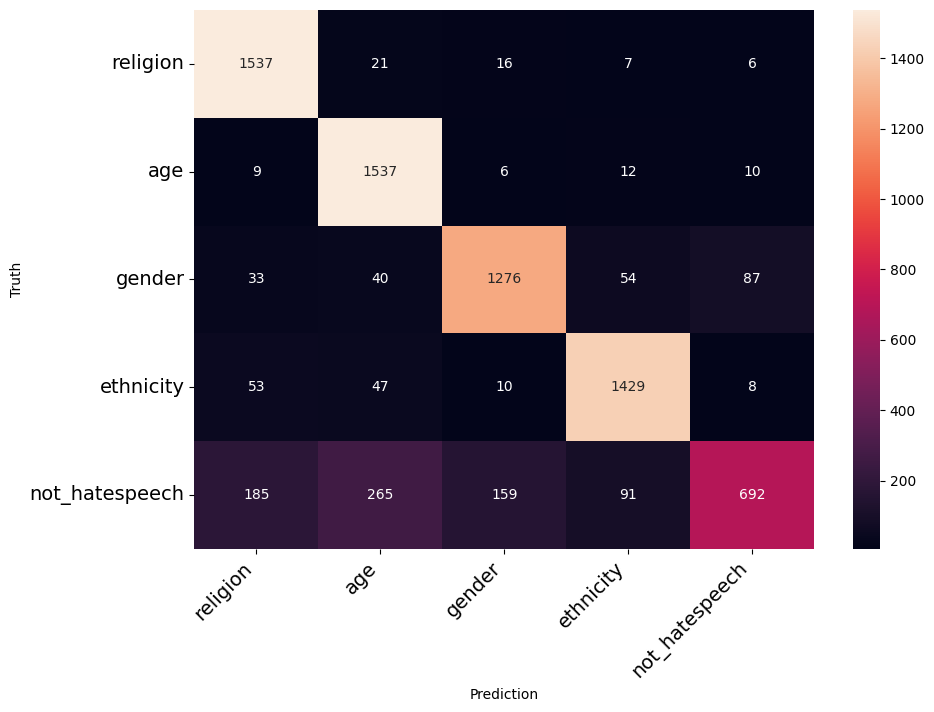

In [40]:
# Naive Bayes
cm = confusion_matrix(y_test,nb_pred)
print_confusion_matrix(cm,typeofhate)

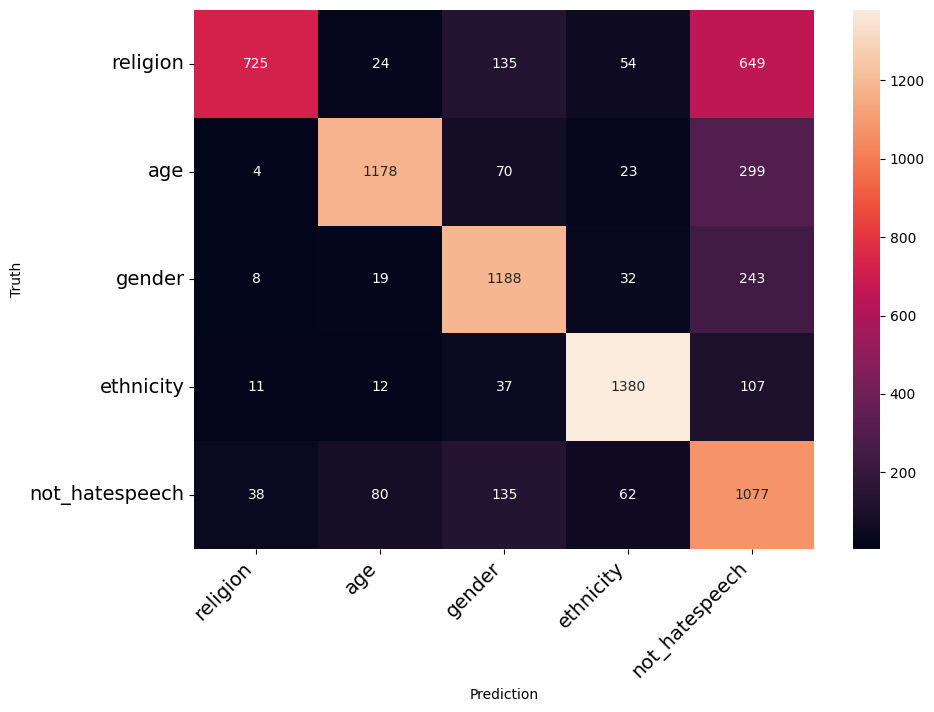

In [41]:
# K Nearest Neighbor
cm = confusion_matrix(y_test,knn_pred)
print_confusion_matrix(cm,typeofhate)

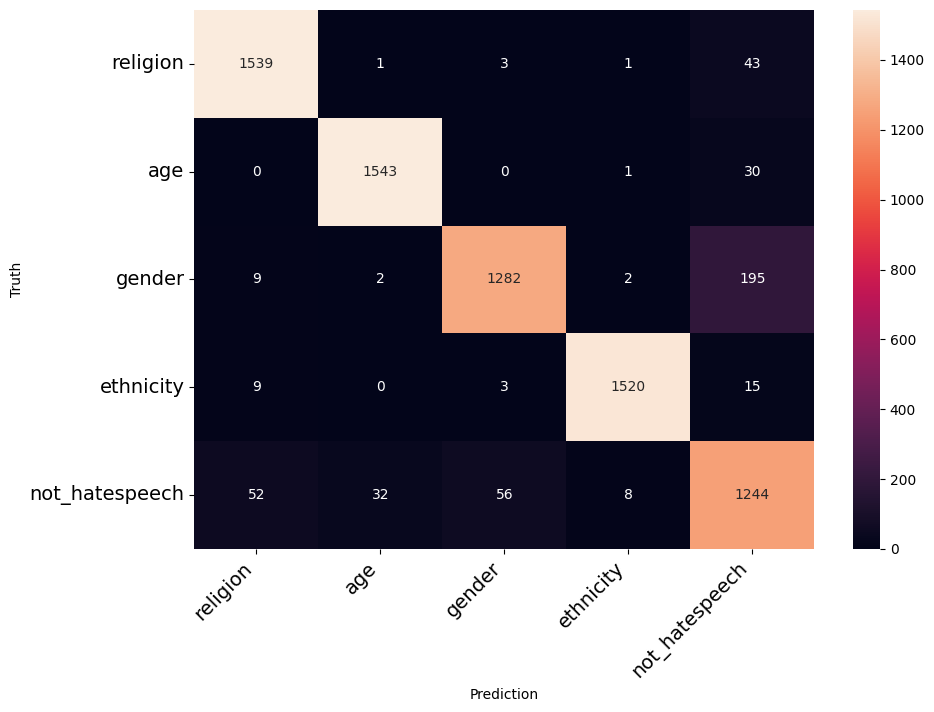

In [42]:
# Random Forest
cm = confusion_matrix(y_test,rf_pred)
print_confusion_matrix(cm,typeofhate)

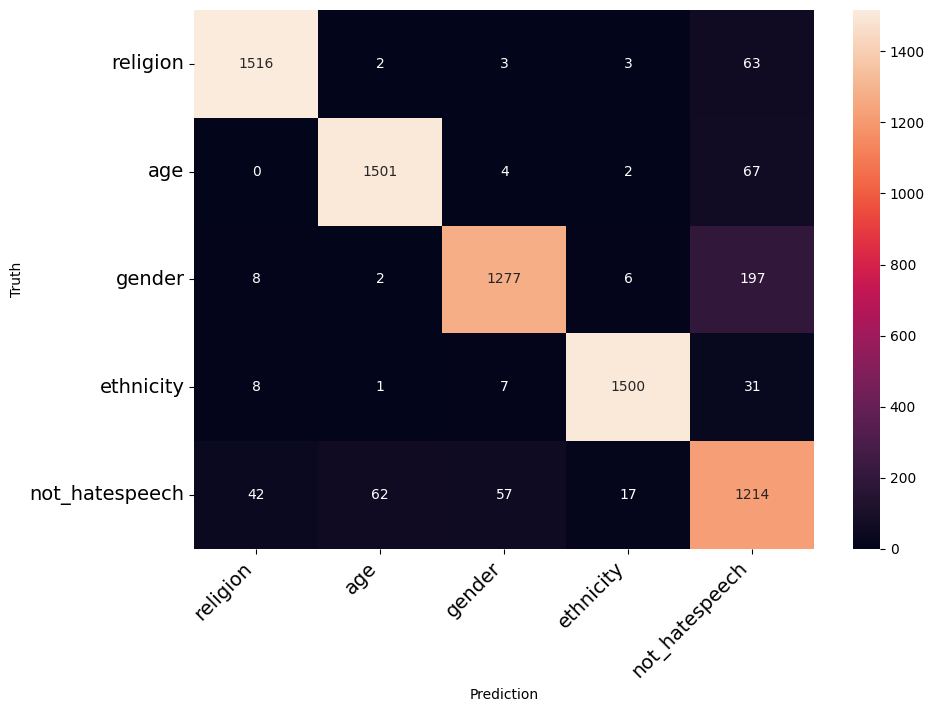

In [43]:
# Logistic Regression
cm = confusion_matrix(y_test,lr_pred)
print_confusion_matrix(cm,typeofhate)

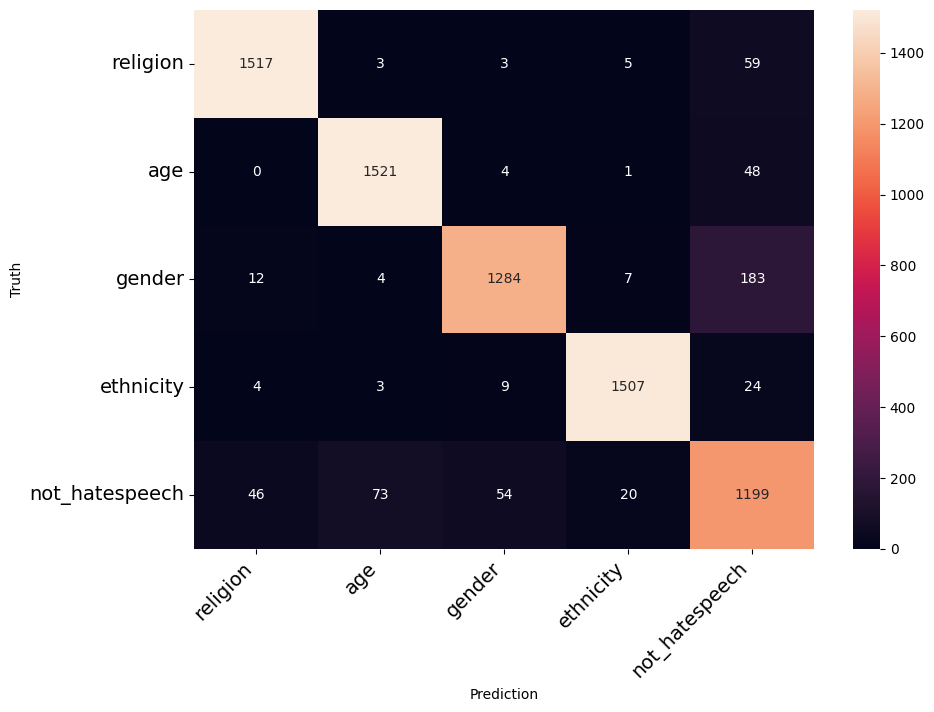

In [44]:
# SVM
cm = confusion_matrix(y_test,svm_pred)
print_confusion_matrix(cm,typeofhate)

### Since we saw that Logistical regression had the highest accuracy, we can try changing a few hyperparameters to see if it can be increased.

In [45]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import make_regression

# # Define the hyperparameters to search over
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'max_depth': [None, 5, 10],
#     'min_samples_split': [2, 5, 10]
# }

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Print the best hyperparameters and score
# print("Best hyperparameters:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)


In [46]:
logreg = LogisticRegression(C=0.937, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Using LSTM for hate speech classification

In [52]:
corpus = []
not_null=df[df['text_clean'].notnull()]
for index, row in not_null.iterrows(): # iterate over each row
        review = row['text_clean']
        review = review.split() # split the sentence into words
        review = ' '.join(review) # join the words back into one sentence
        corpus.append(review) # append the sentence to the corpus

corpus

['word katandandr food crapilici mkr',
 'aussietv white mkr theblock today sunris studio10 neighbour wonderlandten etc',
 'classi whore red velvet cupcak',
 'meh p thank head concern anoth angri dude twitter',
 'isi account pretend kurdish account like islam lie',
 'ye test god good bad indiffer weird whatev prove god exist',
 'itu sekolah ya bukan tempat bulli ga jauh kaya neraka',
 'karma hope bite kat butt nasti mkr',
 'everyth mostli priest',
 'rebecca black drop school due bulli',
 'bulli flush kd',
 'rt turkish state kill 241 children last 11 year news',
 'love best respons hotcak manag film noncommitt meh adolesc mkr',
 'parem de fazer bulli comigo uhahuah bando de preto',
 'tadinhu de mim sofrendo bull viu mimi',
 'twitter basic angri letter gener',
 'best pick line hi cute love peopl call jame potter bulli',
 'got ta walk classss offici hate stupid bu system',
 'know saudi chase girl burn build',
 'kid mohamad bin zay citi',
 'still jack amsterdam ciroc crown bud light limeari

In [53]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split

In [54]:
vocabulary_size = 5000
tokenizer = Tokenizer(num_words=vocabulary_size, split=' ')
tokenizer.fit_on_texts(df['text_clean'].values)
X = tokenizer.texts_to_sequences(df['text_clean'].values)

In [57]:
X = pad_sequences(X)

# Convert the labels to categorical variables
y = pd.get_dummies(df['type_of_hate_speech']).values

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(vocabulary_size, 128, input_length=X.shape[1])) # Embedding layer
model.add(SpatialDropout1D(0.4)) # Dropout layer
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2)) # LSTM layer
model.add(Dense(5, activation='softmax')) # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Evaluate the model
history = model.fit(X_test, y_test, verbose=1) 

Epoch 1/10
475/475 [==============================] - 524s 1s/step - loss: 0.3868 - accuracy: 0.8637 - val_loss: 0.2160 - val_accuracy: 0.9275
Epoch 2/10
475/475 [==============================] - 455s 959ms/step - loss: 0.1698 - accuracy: 0.9406 - val_loss: 0.2143 - val_accuracy: 0.9290
Epoch 3/10
475/475 [==============================] - 472s 995ms/step - loss: 0.1337 - accuracy: 0.9530 - val_loss: 0.2322 - val_accuracy: 0.9235
Epoch 4/10
475/475 [==============================] - 634s 1s/step - loss: 0.1143 - accuracy: 0.9603 - val_loss: 0.2469 - val_accuracy: 0.9249
Epoch 5/10
475/475 [==============================] - 444s 935ms/step - loss: 0.0976 - accuracy: 0.9654 - val_loss: 0.2693 - val_accuracy: 0.9208
Epoch 6/10
475/475 [==============================] - 630s 1s/step - loss: 0.0871 - accuracy: 0.9698 - val_loss: 0.2800 - val_accuracy: 0.9173
Epoch 7/10
475/475 [==============================] - 602s 1s/step - loss: 0.0729 - accuracy: 0.9736 - val_loss: 0.3222 - val_accurac

{'verbose': 1, 'epochs': 1, 'steps': 238}


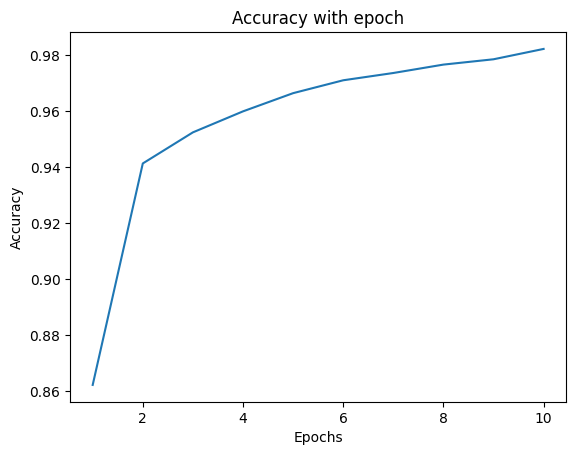

In [ ]:
import matplotlib.pyplot as plt
epochs = 10
print(history.params)
epoch_range = range(1,epochs+1)
# plt.plot(epoch_range,history.history['accuracy'])
# plt.plot(epoch_range,history.history["val_accuracy"])
# print(history.history["accuracy"])
# print(history.history["val_accuracy"])
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["Train","Val"],loc ="upper left")
# plt.show()
# plot_learning_curve(history,10)

#plot the accuracy from above data with epoch
x=[1,2,3,4,5,6,7,8,9,10]
y=[0.8622,0.9413,0.9524,0.9599,0.9664,0.9710,0.9736,0.9766,0.9785,0.9822]
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy with epoch")
plt.plot(x,y)